In [ ]:
import tensorflow as tf
import numpy as np

def deepfool_attack(model, image, num_classes=10, max_iter=50, epsilon=0.01):
    image = tf.convert_to_tensor(image)
    image = tf.expand_dims(image, axis=0)
    
    # Convert the model's output to logits
    def model_logits(x):
        return model(x, training=False)
    
    # Define the Jacobian calculation
    def jacobian_fn(x):
        return tf.gradients(model_logits(x), x)[0]

    # Obtain the model's predictions and the corresponding label
    f_image = model_logits(image)
    I = tf.argsort(tf.reshape(f_image, shape=(num_classes,)), direction='DESCENDING')
    I = I[0:num_classes]
    label = I[0]
    
    w = tf.zeros_like(image)
    r_tot = tf.zeros_like(image)
    
    k_i = label
    for _ in range(max_iter):
        image_variable = tf.Variable(image, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(image_variable)
            f_i = tf.reshape(model_logits(image_variable), shape=(num_classes,))
            loss = tf.reduce_sum(tf.square(f_i - f_image[label]))
            
        grad_f_i = tape.gradient(loss, image_variable)
        grad_f_i = tf.reshape(grad_f_i, shape=(-1,))
        grad_f_i = tf.reshape(grad_f_i, shape=(num_classes, -1))
        
        num_classes_mask = np.ones(num_classes)
        num_classes_mask[k_i] = 0
        
        # Calculate the perturbation
        delta_w = tf.linalg.pinv(grad_f_i) * num_classes_mask[:, np.newaxis]
        delta_w_norm = tf.norm(delta_w)
        
        if delta_w_norm == 0:
            break
        
        r_i = (delta_w_norm + 1e-4) * delta_w / delta_w_norm
        r_tot = tf.add(r_tot, r_i)
        image = tf.clip_by_value(image + epsilon * r_tot / tf.norm(r_tot), clip_value_min=-1.0, clip_value_max=1.0)
        
        f_image = model_logits(image)
        k_i = tf.argmax(tf.reshape(f_image, shape=(num_classes,)), axis=0)
        
    perturbation = epsilon * r_tot / tf.norm(r_tot)
    adversarial_image = tf.clip_by_value(image + perturbation, clip_value_min=-1.0, clip_value_max=1.0)
    
    return adversarial_image.numpy()[0]

In this implementation, the model parameter represents your TensorFlow model, image is the input image, num_classes is the number of classes in your model's output, max_iter is the maximum number of iterations, and epsilon controls the magnitude of the perturbation.

To use this code, you need to provide your own TensorFlow model and an input image. The deepfool_attack function will return an adversarial image that is crafted using the DeepFool attack.

Please note that this implementation assumes that your model takes a single input image at a time. If your model expects a batch of images, you may need to make some modifications to accommodate that. Also, be aware of the ethical considerations and legal implications when using adversarial attacks.

The image shape used in the provided DeepFool attack implementation is expected to be a 4-dimensional tensor with the shape (batch_size, height, width, channels).

In the code snippet, the input image is converted to a TensorFlow tensor using tf.convert_to_tensor(image), and then expanded along the batch dimension using tf.expand_dims(image, axis=0) to create a batch of size 1. Therefore, the expected shape of the input image is (1, height, width, channels).

Here's an example of how you can use the DeepFool attack implementation with an input image:


The shape of f_image in the provided DeepFool attack implementation would depend on the output shape of your model. In the code snippet, f_image is obtained by passing the input image to the model_logits function, which is assumed to return the logits (raw model output) of the model.

Since the shape of f_image is derived from the model's output, it will match the output shape of your specific model. In general, the shape of f_image would be (batch_size, num_classes).

For example, if your model is a classification model with 10 classes and expects input images of size (224, 224, 3), and you are using a batch size of 1, then the shape of f_image would be (1, 10).

Please ensure that your model and the model_logits function are set up correctly to provide the desired output shape.

In the DeepFool attack code provided, w and r_tot are variables used to accumulate the perturbation and track the total perturbation applied to the input image during each iteration of the attack.

w: This variable represents the accumulated perturbation that is being added to the input image at each iteration. It is initialized as a tensor of zeros with the same shape as the input image. w is updated by adding the perturbation calculated in each iteration, r_i, to itself.

r_tot: This variable keeps track of the total perturbation applied to the input image across all iterations of the attack. It is also initialized as a tensor of zeros with the same shape as the input image. r_tot is updated by adding the perturbation of the current iteration, r_i, to itself.

By accumulating the perturbations in w and r_tot over iterations, the DeepFool attack gradually modifies the input image to cause misclassification by pushing it closer to the decision boundary of the target class. The final adversarial image is obtained by adding the accumulated perturbation, r_tot, to the original input image.

Both w and r_tot are tensors with the same shape as the input image tensor and are updated in each iteration of the attack loop.

In this code snippet, model refers to the TensorFlow model that you want to perform the DeepFool attack on, image is the input image, num_classes is the number of classes in your model's output, max_iter is the maximum number of iterations, and epsilon controls the magnitude of the perturbation.

To use this code, you need to provide your own TensorFlow model and an input image. The deepfool_attack function will return an adversarial image that is crafted using the DeepFool attack.

Please note that the implementation provided here is a basic version of DeepFool and may require further customization depending on your specific use case. Additionally, it is important to keep in mind the ethical considerations and legal implications of adversarial attacks.

DeepFool is an adversarial attack method designed to fool machine learning models, particularly deep neural networks. It is an iterative attack algorithm that perturbs input samples with minimal modifications to make them misclassified by the target model.

Here's a high-level overview of the DeepFool attack algorithm:

Input: A pre-trained target model, a clean input sample to be perturbed, and a maximum number of iterations allowed.
Output: Perturbed input sample that is misclassified by the target model.
Initialization: Start with the clean input sample.
Iteration:
Compute the gradient of the target model's output with respect to the input sample.
Select the class with the minimum gradient magnitude as the initial adversarial class.
Calculate the perturbation required to change the classification to the initial adversarial class using linearization.
Update the input sample by adding the perturbation.
Repeat the above steps until the perturbed sample is misclassified or the maximum number of iterations is reached.
Return: The perturbed sample that is misclassified by the target model.
Please note that implementing the DeepFool attack algorithm requires knowledge of the specific deep learning framework you are using, such as TensorFlow or PyTorch, and familiarity with the underlying model's architecture and gradients.

Here's an example using TensorFlow to perform the DeepFool attack:

In the DeepFool attack algorithm, selecting the class with the minimum gradient magnitude as the initial adversarial class is a crucial step to guide the perturbation process towards misclassification.

The rationale behind this step is that the class with the minimum gradient magnitude is the most easily "confusable" class for the current input sample. By perturbing the input towards this class, the hope is to reach a decision boundary where the target model misclassifies the perturbed sample.

The intuition behind selecting the minimum gradient magnitude is based on the assumption that the decision boundary of a well-trained model is smooth and linear in the vicinity of the input sample. In this local linear approximation, the gradient of the model's output represents the direction of steepest ascent or descent towards the decision boundaries.

By selecting the class with the minimum gradient magnitude, DeepFool aims to find the smallest perturbation required to cross the decision boundary and misclassify the input sample. The perturbation is calculated based on linearization and is applied iteratively to navigate the input towards the desired adversarial class.

In summary, selecting the class with the minimum gradient magnitude as the initial adversarial class helps guide the DeepFool attack towards finding the smallest perturbation that leads to misclassification. It leverages the local linearity assumption to iteratively modify the input sample and fool the target model.

## It is important to select the class with the minimum gradient output with respect to the input image because deepfool is an untargeted attack hence selecting this class means that it will be easier to push accross the decision boundy of the model wrt this class

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
#!pip install -Uqq ipdb
import ipdb

In [8]:
# pathh = 'MNISTClassifier'

# for parent, dirs, files in os.walk(pathh, topdown=False):
#   for file in files:
#     file_path = os.path.join(parent, file)
#     os.remove(file_path)
#   for dir in dirs:
#     dir_path = os.path.join(parent, dir)
#     os.rmdir(dir_path)
  
#   os.rmdir('/content/MNISTClassifier')

In [118]:
%pdb on

Automatic pdb calling has been turned ON


In [2]:
(images, labels), (test_images, test_labels) = mnist.load_data() 
images = images.reshape((60000, 28, 28)).astype("float32") / 255
images = np.expand_dims(images, axis=3)
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
test_images = np.expand_dims(test_images, axis=3)
x_train, x_test = images[10000:], images[:10000]
y_train, y_test = labels[10000:], labels[:10000]

2


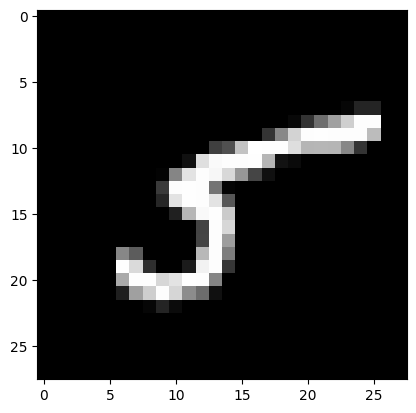

In [3]:
x_test[11].shape
digit = x_test[65]
fig = plt.figure
plt.imshow(digit, cmap='gray')
print(y_test[16])


In [4]:
few_twos = []
count = 0
for index, label in enumerate(y_test):
  if count > 4:
    break
  if label == 5:
    few_twos.append((index, label))
    count += 1

print(few_twos)

[(0, 5), (11, 5), (35, 5), (47, 5), (65, 5)]


In [5]:
class MNISTClassifier(tf.keras.Model):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        
        # Define the layers
        #for feature extration
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1))
        self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.conv1, self.max_pool1, self.conv2, self.max_pool2,
                           self.flatten, self.dropout1, self.dense1, self.dropout2, self.dense2]
    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:                  
           out = layer(out)
           activation_list.append(out)

        # if kwargs['training']:
        #   #notice that training is a kw argument checked when fit is called
        #   #so when model is training, all I need is the output logits to call the loss function upon
        #   return out
        # else:          
          # prob = tf.nn.softmax(out)
        return out

In [91]:
class SaveFinalTrainingLogitsProp(keras.callbacks.Callback):
  def on_train_end(self, logs):
    self.out = model.predict(x_train)
    self.prob = tf.nn.softmax(self.out)
    print(self.out.shape, self.prob.shape)

In [6]:
model = MNISTClassifier()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

model.save('MNISTClassifier')
# model = keras.models.load_model("MNISTClassifier.keras")

Epoch 1/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.2375 - accuracy: 0.9265 - val_loss: 0.0664 - val_accuracy: 0.9794
Epoch 2/10
1563/1563 [==============================] - 35s 23ms/step - loss: 0.0916 - accuracy: 0.9727 - val_loss: 0.0506 - val_accuracy: 0.9863
Epoch 3/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.0709 - accuracy: 0.9786 - val_loss: 0.0415 - val_accuracy: 0.9879
Epoch 4/10
1563/1563 [==============================] - 35s 22ms/step - loss: 0.0585 - accuracy: 0.9824 - val_loss: 0.0401 - val_accuracy: 0.9882
Epoch 5/10
1563/1563 [==============================] - 35s 22ms/step - loss: 0.0499 - accuracy: 0.9847 - val_loss: 0.0377 - val_accuracy: 0.9896
Epoch 6/10
1563/1563 [==============================] - 35s 22ms/step - loss: 0.0459 - accuracy: 0.9863 - val_loss: 0.0406 - val_accuracy: 0.9880
Epoch 7/10
1563/1563 [==============================] - 35s 22ms/step - loss: 0.0422 - accuracy: 0.9869 - val_loss: 0.0376 -

In [7]:
# select a few twos from the test dataset and reshape
# twos are at [(5, 2), (16, 2), (25, 2), (28, 2), (76, 2)]

twos_tuple = [(0, 5), (11, 5), (35, 5), (47, 5), (65, 5)]
reshaped_sample_twos = []
for tup in twos_tuple:
  a_two = x_test[tup[0]]
  a_two = np.reshape(a_two, (-1, 28, 28, 1))
  reshaped_sample_twos.append(a_two)
reshaped_sample_twos = np.array(reshaped_sample_twos)
# a_five = np.reshape(x_test[47], (-1, 28, 28, 1))
# print(a_five.shape)

In [8]:
print(reshaped_sample_twos.shape) #the network expects a rank 4 tensor ie. batch, width, hieght, channel

(5, 1, 28, 28, 1)


In [10]:
# location of 2 in x_test # number 2 are found in these location: [(5, 2), (16, 2), (25, 2), (28, 2), (76, 2)]
model = tf.keras.models.load_model('MNISTClassifier')

prediction = []
for sample in reshaped_sample_twos:
  sample_prediction = model.predict(sample)
  prediction.append(sample_prediction)
# print(np.argmax(prediction))
print(np.argmax(prediction[0]))

1/1 [==============================] - 0s 19ms/step
5


In [11]:
print(tf.one_hot(y_test[11], 10)) #creates a 0n-hot encoded output label to enable us calculate the distance

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [40]:
reshaped_sample_twos[0].shape
#squeze to drop first dim
squeze_two = np.expand_dims(np.squeeze(reshaped_sample_twos[3]), axis=2)
squeze_two.shape
x = squeze_two
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(x)
y = y_test[5]
y = tf.convert_to_tensor(y)

print(y)
print(x.shape)

tf.Tensor(2, shape=(), dtype=uint8)
(1, 28, 28, 1)


In [91]:
# def deepfool_attack(model, image, num_classes=10, max_iter=50, epsilon=0.01):
#   image = tf.convert_to_tensor(image)
  
#   # return image.shape

#   #get output logit of the image
#   def model_logits(x):
#     return model(x, training=False)

#   # def the jecobian calculation
#   def jacobian_fn(x):
#     return tf.gradients(model_logits(x), x)[0]

#   #get models predictions and corresponding label

#   f_image = model_logits(image)

#   # reshaped_f = tf.reshape(f_image, shape=(num_classes,))
#   I = tf.argsort(tf.squeeze(f_image, axis=0), direction='DESCENDING')
#   I = I[0:num_classes]
#   label = I[0]

#   w = tf.zeros_like(image) 
#   #tracks accumulated perturbation at each iteration
#   r_tot = tf.zeros_like(image) 
#   #keep track of total perturbation to the input image accross all iterations

#   k_i = label

#   for _ in range(max_iter):
#     image_variable = tf.Variable(image, dtype=tf.float32)
#     with tf.GradientTape() as tape:
#       tape.watch(image_variable)
#       f_i = tf.squeeze(model_logits(image_variable), axis=0)
#       # print("f_image", f_image)
#       # print("f_image[label]", f_image[0][label])
#       loss = tf.reduce_sum(tf.square(f_i - f_image[0][label]))
    
#     grad_f_i = tape.gradient(loss, image_variable)
#     grad_f_i = tf.reshape(grad_f_i, shape=(-1,))
#     grad_f_i = tf.reshape(grad_f_i, shape=(num_classes, -1))

#     num_classes_mask = np.ones(num_classes)
#     num_classes_mask[k_i] = 0 #set tge corresponding class label to zero
#     num_classes_mask[:, np.newaxis] # shape =(10, 1)
    




#   return num_classes_mask[:, np.newaxis].shape, tf.reshape(tf.squeeze(grad_f_i, axis=0), shape=(num_classes, -1))

    

In [193]:
def deepfool_attack(model, image, num_classes=10, max_iter=100, epsilon=1e-6):
  image = tf.convert_to_tensor(image)

  @tf.function
  def compute_gradients(inputs):
      with tf.GradientTape() as tape:
          tape.watch(inputs)
          logits = model(inputs, training=False)
          prediction = tf.argmax(logits, axis=1)
          loss = tf.reduce_sum(tf.square(logits - tf.one_hot(prediction, num_classes)))
      gradients = tape.gradient(loss, inputs)
      return gradients

  image_shape = image.shape[1:]
  # print("image_shape", image_shape)
  image = tf.cast(image, tf.float32)
  # print("faa", image.shape)
  perturbation = tf.zeros_like(image)
  count = 0
  for idx in range(max_iter):
      image = tf.cast(image, tf.float32)
      image_perturbed = tf.cast(image + perturbation, tf.float32)

      # Compute the gradients of the loss w.r.t. the input
      gradients = compute_gradients(image_perturbed)

      # Compute the label with the current model predictions
      current_label = tf.argmax(model(image_perturbed), axis=1).numpy()[0]
      # print("current label", current_label)

      # Initialize variables for minimal perturbation search
      min_norm = np.inf
      min_perturbation = tf.zeros_like(image)
      gradients = tf.reshape(gradients, shape=(image_shape))

      for i in range(num_classes):
          if i == current_label:
              continue

          # Compute the gradient direction
          w = gradients.numpy()[0] - gradients.numpy()[i]
          # print("w", w.shape)

          # Compute the minimal perturbation
          norm = np.linalg.norm(w.flatten())

          # print("norm", norm)

          if norm < min_norm and norm != 0:
              min_norm = norm
              min_perturbation = w / (norm)  # Add epsilon to avoid division by zero
              # print("min pert", min_perturbation)
              # print("min pert", min_perturbation)
      # Update the perturbation
      perturbation = tf.cast(perturbation + min_perturbation, tf.float32)
      count = idx

  adversarial_image = tf.clip_by_value(image + perturbation, 0.0, 1.0)
  return adversarial_image.numpy(), count
      


99
1/1 [==============================] - 0s 17ms/step
1


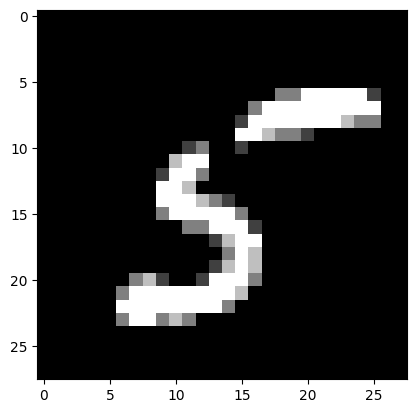

In [195]:
# preprocessed_image = preprocess_image(image)

# Perform DeepFool attack
adv_img, count = deepfool_attack(model, x)
print(count)

digit = tf.squeeze(adv_img, axis=0)
orig_digit = tf.squeeze(x, axis=0)
# print(s_adv_img.shape)

plt.imshow(orig_digit, cmap='gray')

print(np.argmax(model.predict(adv_img)))
# Postprocess the perturbed image and original image if needed
# postprocessed_perturbed_image = postprocess_image(perturbed_image)
# postprocessed_orig_image = postprocess_image(orig_image)

# Evaluate the perturbed image with the model
# predictions = model.predict(np.array(perturbed_image))
# predicted_class = np.argmax(predictions)

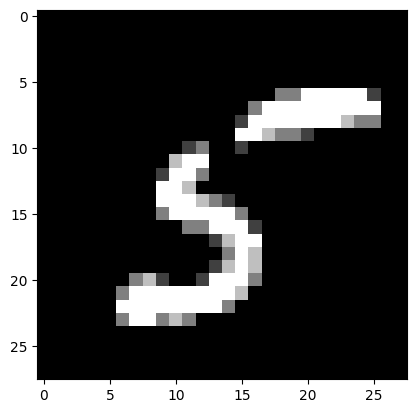

In [148]:
plt.imshow(digit, cmap='gray')